In [21]:
from sklearn import datasets
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_decision_regions(X,y,classifier,test_idx = None, resolution = 0.02):
    
    # set up marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #plot decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1

    xx1,xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1,xx2,lab,alpha=0.3,cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl,0],
                    y = X[y == cl, 1],
                    alpha = 0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = f'Class {cl}',
                    edgecolor = 'black')
        
    #highlight test examples
    if test_idx:
        #plot all examples
        X_test,y_test = X[test_idx,:], y[test_idx]

        plt.scatter(X_test[:,0],X_test[:,1],
                    c = 'none', edgecolor = 'black', alpha = 1.0,
                     linewidth = 1, marker = 'o',
                      s=100, label =  'Test Set')



In [3]:
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('Class Labels :', np.unique(y))

Class Labels : [0 1 2]


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.3, random_state = 1, stratify=y
)

In [29]:
#stratify will ensure that there are the same proportions of each label in train/test 
#as exist in the full dataset
print('Labels counts in y:', np.bincount(y))
print('Labels counts in train_y:', np.bincount(y_train))
print('Labels counts in test_y:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in train_y: [35 35 35]
Labels counts in test_y: [15 15 15]


In [30]:
#scales features to mean = zero and stdev = 1
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

# Perceptron

In [15]:
ppn = Perceptron(eta0 = 0.1,random_state = 1)
ppn.fit(X_train_sc, y_train)
y_pred = ppn.predict(X_test_sc)
print('Misclassified examples : %d' %(y_test != y_pred).sum()) 

Misclassified examples : 1


In [17]:
print('Accuracy : %.3f' % accuracy_score(y_test,y_pred))

Accuracy : 0.978


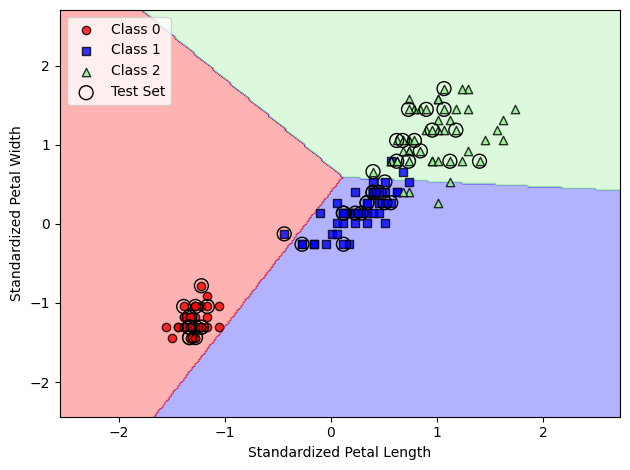

In [ ]:
X_combined_sc = np.vstack((X_train_sc, X_test_sc))
y_combined = np.hstack((y_train,y_test))

plot_decision_regions(X=X_combined_sc,
                      y = y_combined,
                      classifier= ppn,
                      test_idx=range(105,150))
plt.xlabel('Standardized Petal Length')
plt.ylabel('Standardized Petal Width')

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()


# Logistic Regression

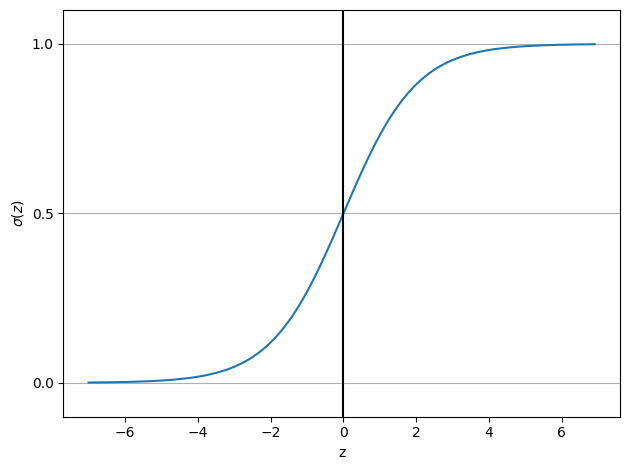

In [23]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7,7,0.1)

sigma_z = sigmoid(z)

plt.plot(z,sigma_z)

plt.axvline(0.0,color = 'k')

plt.ylim(-0.1,1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()


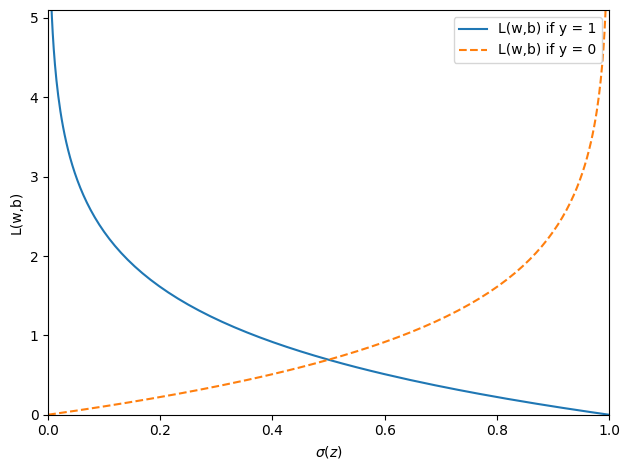

In [25]:
def loss_1(z):
    return -np.log(sigmoid(z))
def loss_0(z):
    return -np.log(1-sigmoid(z))

z = np.arange(-10,10,0.1)
sigma_z = sigmoid(z)

c1 = [loss_1(x) for x in z]
plt.plot(sigma_z,c1,label = 'L(w,b) if y = 1')

c0 = [loss_0(x) for x in z]
plt.plot(sigma_z,c0,linestyle = '--',label = 'L(w,b) if y = 0')

plt.ylim(0.0,5.1)
plt.xlim([0,1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w,b)')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [35]:
class LogisticRegressionGD:
    """Gradient Descent-based ligistic regression classifier.
    
    Parameters
    ----------
    eta : float (learning rate between 0.0 - 1.0)
    n_iter : int (# passes over the training dataset)
    random_state: int (random number generator for weight initialization)
    
    Attributes
    ----------
    w_ : 1d-array (weights after fitting)
    b_ : scalar (bias unit after fitting)
    losses_ : list (Mean Squared Error Loss function values in each epoch)
    
    """

    def __init__(self,eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self,X,y):
        """Fit Training Data.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examp[les, n_features]
            Training vectors, where n_examples is the number of examples 
            and n_features is the number of features. 
        y : array-like, shape = [n_examples]
            Target values

        Returns
        -------
        self : Instance of LogisticRegressionGD

        """

        rgen = np.random.RandomState(self.random_state)

        #initialize weights, biases, and losses
        # weights are random in shape of X, biases are zero, losses are empty list
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y-output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output)) - 
                    ((1-y).dot(np.log(1-output))) 
                    / X.shape[0])
            self.losses_.append(loss)
        return self
    
    def net_input(self,X):
        """Calculate net input"""
        return np.dot(X,self.w_) + self.b_
    
    def activation(self,z):
        """Compute logistic sigmoid activation"""
        return 1.0 / (1. + np.exp(-np.clip(z,-250,250)))
    
    def predict(self,X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5,1,0)

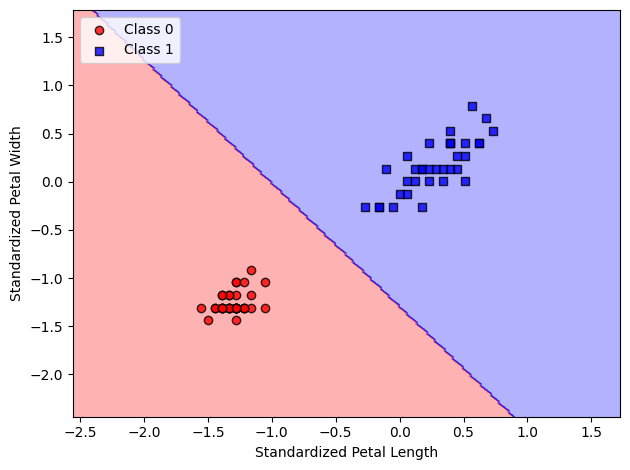

In [ ]:
X_train_01_subset = X_train_sc[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state = 1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X = X_train_01_subset,
                      y = y_train_01_subset,
                      classifier = lrgd)

plt.xlabel('Standardized Petal Length')
plt.ylabel('Standardized Petal Width')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

/Users/sarah/anaconda3/envs/SWMLA/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


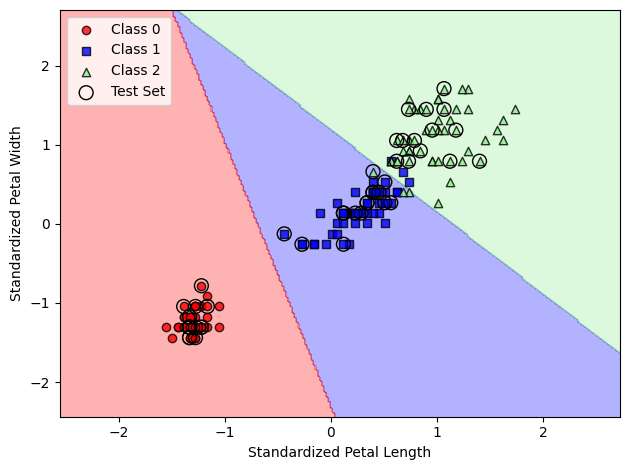

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 100., solver = 'lbfgs', multi_class= 'ovr')
lr.fit(X_train_sc, y_train)
plot_decision_regions(X_combined_sc,
                      y_combined,
                      classifier= lr,
                      test_idx = range(105,150))

plt.xlabel('Standardized Petal Length')
plt.ylabel('Standardized Petal Width')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# Regularization

/Users/sarah/anaconda3/envs/SWMLA/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sarah/anaconda3/envs/SWMLA/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sarah/anaconda3/envs/SWMLA/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sarah/anaconda3/envs/SWMLA/lib/python3.11/

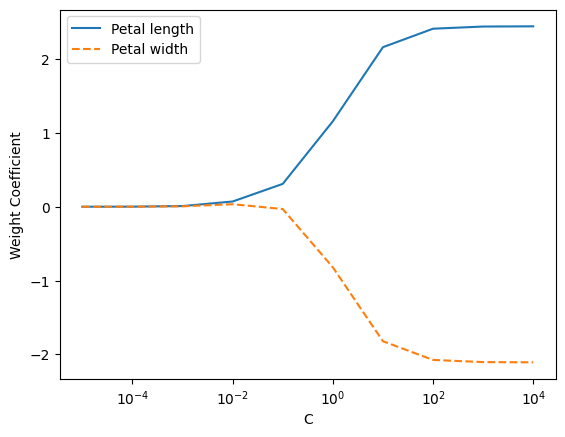

In [40]:
weights, params = [],[]
for c in np.arange(-5,5):
    lr = LogisticRegression(C = 10.**c,
                            multi_class='ovr')
    lr.fit(X_train_sc,
           y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:,0], label = 'Petal length')
plt.plot(params, weights[:,1], linestyle = '--', label = 'Petal width')

plt.ylabel('Weight Coefficient')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()
